# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

*This notebook was generated with the assistance of AI. Please interpret the code and results with caution, and verify steps before using them for scientific research.*

## Overview

This notebook introduces and explores **Dandiset 001361**, a dataset containing two-photon imaging and behavioral data from the hippocampal CA1 region of mice performing virtual navigation tasks. The data is part of the study:

**"A flexible hippocampal population code for experience relative to reward"**  
Marielena Sosa, Mark H. Plitt, Lisa M. Giocomo (Nature Neuroscience)

Dandiset Link: [https://dandiarchive.org/dandiset/001361/0.250406.0045](https://dandiarchive.org/dandiset/001361/0.250406.0045)

This notebook shows how to:
- List and inspect files in the Dandiset using the DANDI API
- Load example NWB files remotely
- Visualize mouse behavioral data (track position over time)
- Visualize deconvolved calcium signals for a subset of cells
- Plot segmentation mask contours for the first few ROIs in pixel coordinate space

All data access here is done by streaming from the DANDI archive—no downloading required.

## Required Packages

To run this notebook, the following packages are required (assume they are installed):

- `dandi`
- `remfile`
- `h5py`
- `numpy`
- `matplotlib`
- `skimage`

These packages enable remote access, inspection, and visualization of NWB data files from the DANDI Archive.

## 1. List NWB Files in the Dandiset

Let's start by accessing the Dandiset and listing a few of the available NWB files using the DANDI API.

In [1]:
from dandi.dandiapi import DandiAPIClient

DANDISET_ID = "001361"
DANDISET_VERSION = "0.250406.0045"

# Connect to the DANDI Archive (read-only)
client = DandiAPIClient()
dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)

# List the first 10 NWB files in the Dandiset
assets = dandiset.get_assets_by_glob("*.nwb")
filenames = [asset.path for asset in list(assets)[:10]]
for i, fn in enumerate(filenames):
    print(f"{i+1}. {fn}")

1. sub-m11/sub-m11_ses-05_behavior+ophys.nwb
2. sub-m11/sub-m11_ses-04_behavior+ophys.nwb
3. sub-m11/sub-m11_ses-07_behavior+ophys.nwb
4. sub-m11/sub-m11_ses-06_behavior+ophys.nwb
5. sub-m11/sub-m11_ses-08_behavior+ophys.nwb
6. sub-m11/sub-m11_ses-10_behavior+ophys.nwb
7. sub-m11/sub-m11_ses-03_behavior+ophys.nwb
8. sub-m11/sub-m11_ses-09_behavior+ophys.nwb
9. sub-m11/sub-m11_ses-11_behavior+ophys.nwb
10. sub-m11/sub-m11_ses-12_behavior+ophys.nwb


## 2. Load an Example NWB File (Remote Streaming)

We'll work with the following file as an example:  
**sub-m11/sub-m11_ses-05_behavior+ophys.nwb**

This file contains both behavior and two-photon imaging for one session.

In [2]:
NWB_PATH = "sub-m11/sub-m11_ses-05_behavior+ophys.nwb"
asset = next(dandiset.get_assets_by_glob(NWB_PATH))
url = asset.download_url  # We'll use this for remote streaming

## 3. Behavioral Data: Mouse Position Over Time

Let's load the mouse's position on the virtual track over time from the NWB file, and plot it to visualize the behavioral structure of the session.

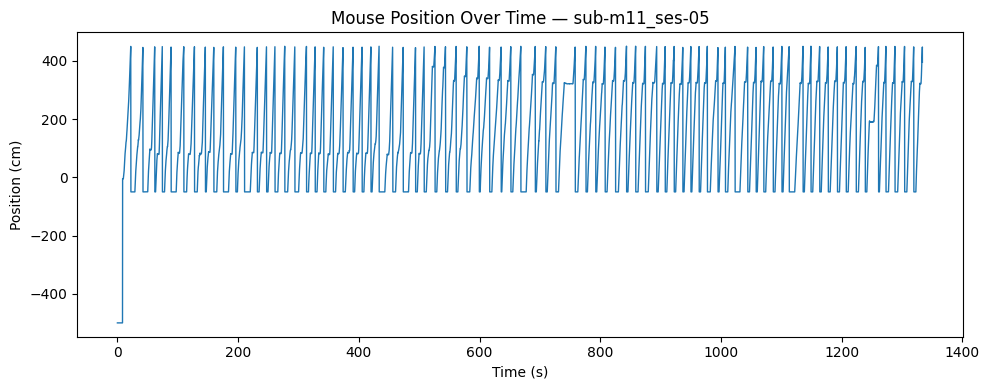

In [3]:
import remfile
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Open NWB file remotely and extract behavioral position and timestamps
with h5py.File(remfile.File(url), 'r') as f:
    pos_path = 'processing/behavior/BehavioralTimeSeries/position'
    position = f[pos_path + '/data'][:]
    timestamps = f[pos_path + '/timestamps'][:]

# Plot the position over time
plt.figure(figsize=(10, 4))
plt.plot(timestamps, position, lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title('Mouse Position Over Time — sub-m11_ses-05')
plt.tight_layout()
plt.show()

**Interpretation:**  
The repeated ramp profiles indicate structured "laps" or trials, as the mouse traverses a virtual linear track in multiple cycles. Occasional negative or zero values may correspond to session initialization or trial resets.

## 4. Neural Data: Deconvolved Calcium Activity for Example Cells

We'll plot the deconvolved activity traces of the first ten cells for this session, giving a sense of the sample neural dynamics.

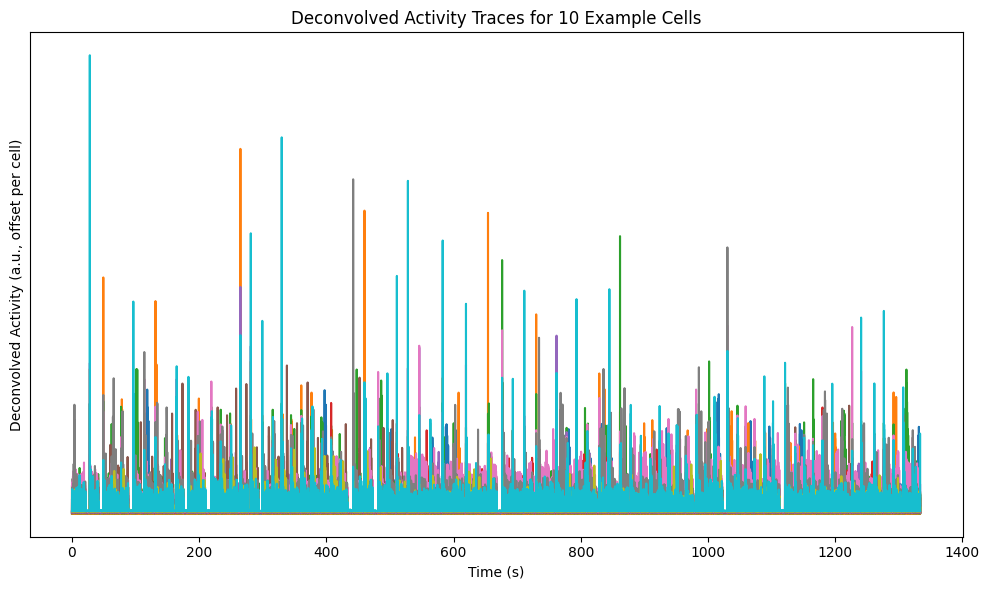

In [4]:
# Load deconvolved traces for the first 10 cells
with h5py.File(remfile.File(url), 'r') as f:
    d_path = 'processing/ophys/Deconvolved/plane0/data'
    data = f[d_path][:, :10]  # (frames, 10 cells)
    # Get timing info (sampling rate and starting time)
    starting_time = f['processing/ophys/Deconvolved/plane0/starting_time'][()]
    sampling_rate = 15.5078125  # Known for this dataset
    num_frames = data.shape[0]
    time = np.arange(num_frames) / sampling_rate + starting_time

# Offset for clarity
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(time, data[:, i] + i * 7, label=f'Cell {i}')
plt.xlabel('Time (s)')
plt.ylabel('Deconvolved Activity (a.u., offset per cell)')
plt.title('Deconvolved Activity Traces for 10 Example Cells')
plt.yticks([])
plt.tight_layout()
plt.show()

**Notes:**  
The traces show sparse, transient events. Each cell's activity trace is vertically offset for visual clarity.

## 5. Segmentation: ROI Contours for the First 10 Cells (No Anatomical Background)

Segmentation results are often provided as pixel masks ("pixel_mask"), representing the locations of each identified cell (ROI). Here we visualize just the contours (shapes) of the first ten ROIs in their coordinate space (without attempting anatomical registration to the background).

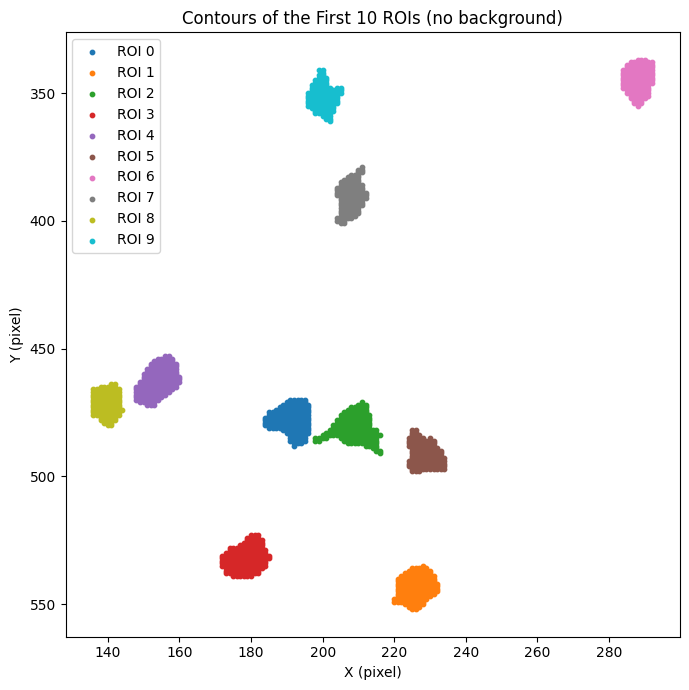

In [5]:
from skimage import measure

# Load ROI masks (pixel_mask) for first 10 ROIs
with h5py.File(remfile.File(url), 'r') as f:
    pixel_mask = f['processing/ophys/ImageSegmentation/PlaneSegmentation/pixel_mask'][:]
    pixel_mask_index = f['processing/ophys/ImageSegmentation/PlaneSegmentation/pixel_mask_index'][:]
    num_rois = 10
    roi_xy = []
    for i in range(num_rois):
        start = pixel_mask_index[i-1] if i > 0 else 0
        end = pixel_mask_index[i]
        mask_entries = pixel_mask[start:end]
        xy = np.array([(entry[0], entry[1]) for entry in mask_entries])
        roi_xy.append(xy)

# Plot contours of ROIs (no background)
plt.figure(figsize=(7, 7))
colors = plt.cm.tab10(np.linspace(0, 1, num_rois))
for i, xy in enumerate(roi_xy):
    if xy.shape[0] > 0:
        plt.scatter(xy[:, 0], xy[:, 1], s=10, color=colors[i], label=f'ROI {i}')
plt.gca().invert_yaxis()
plt.xlabel('X (pixel)')
plt.ylabel('Y (pixel)')
plt.title('Contours of the First 10 ROIs (no background)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Interpretation:**  
Each colored cluster represents the segmented region for one ROI (cell). This view is useful to verify ROI shapes and relative coverage, even though there is no anatomical background.

## Summary

- We listed available NWB files in Dandiset 001361.
- We loaded behavioral and neural data from an example session using remote streaming.
- We visualized mouse position, neural population activity, and segmentation masks.

This notebook provides a framework for further analysis and re-use of the hippocampal imaging dataset on the DANDI Archive.